In [1]:
import torch

from plot_domination import plot_pareto_domination, plot_scalarized_domination
from scalarize.utils.scalarization_functions import (
    ChebyshevScalarization,
    LpScalarization,
    HypervolumeScalarization,
    KSScalarization,
    LengthScalarization,
)

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
N = 200
X = torch.linspace(-0.05, 1.05, N)
Y = torch.linspace(-0.05, 1.05, N)
A, B = torch.meshgrid(X, Y, indexing="xy")

# (N*N x 2)-dim array
Z = torch.column_stack([A.reshape(N * N, 1), B.reshape(N * N, 1)])

r = torch.tensor([[0.3, 0.25]])
utopia = torch.tensor([[0.6, 0.75]])
nadir = torch.tensor([[0.025, 0.025]])
w = torch.tensor([[0.55, 0.45]])
h = 1 / w
h = h / h.pow(2).sum().pow(1 / 2)

utopia_set = torch.tensor(
    [
        [0.5, 0.8],
        [0.6, 0.75],
        [0.7, 0.7],
        [0.75, 0.6],
        [0.8, 0.5],
    ]
)

In [3]:
levels = None  # torch.linspace(-2, 2, 101)
s_fn_dict = {
    r"$-d^{\text{IGD}_1}(\mathbf{y}, \boldsymbol{\upsilon})$": [
        LpScalarization(p=1, weights=w, ref_points=utopia),
        utopia,
        None,
        None,
        None,
    ],
    r"$-d^{\text{IGD}_2}(\mathbf{y}, \boldsymbol{\upsilon})$": [
        LpScalarization(p=2, weights=w, ref_points=utopia),
        utopia,
        None,
        None,
        None,
    ],
    r"$-d^{\text{IGD}_1+}(\mathbf{y}, \boldsymbol{\upsilon})$": [
        LpScalarization(p=1, weights=w, ref_points=utopia, clip=True),
        utopia,
        None,
        None,
        None,
    ],
    r"$-d^{\text{IGD}_2+}(\mathbf{y}, \boldsymbol{\upsilon})$": [
        LpScalarization(p=2, weights=w, ref_points=utopia, clip=True),
        utopia,
        None,
        None,
        None,
    ],
    r"$-d^{\text{D1}}(\mathbf{y}, \boldsymbol{\upsilon})$": [
        ChebyshevScalarization(weights=w, ref_points=utopia),
        utopia,
        None,
        None,
        None,
    ],
    r"$d^{\text{Length}}(\boldsymbol{\eta}, \mathbf{y})$": [
        LengthScalarization(weights=h, ref_points=nadir, clip=True),
        None,
        nadir,
        h,
        None,
    ],
    r"$d^{\text{HV}}(\boldsymbol{\eta}, \mathbf{y})$": [
        HypervolumeScalarization(weights=h, ref_points=nadir),
        None,
        nadir,
        h,
        levels,
    ],
    r"$s^{\text{KS}}_{(\boldsymbol{\eta}, \boldsymbol{\upsilon})}(\mathbf{y})$": [
        KSScalarization(utopia_points=utopia, nadir_points=nadir),
        utopia,
        nadir,
        None,
        None,
    ],
}

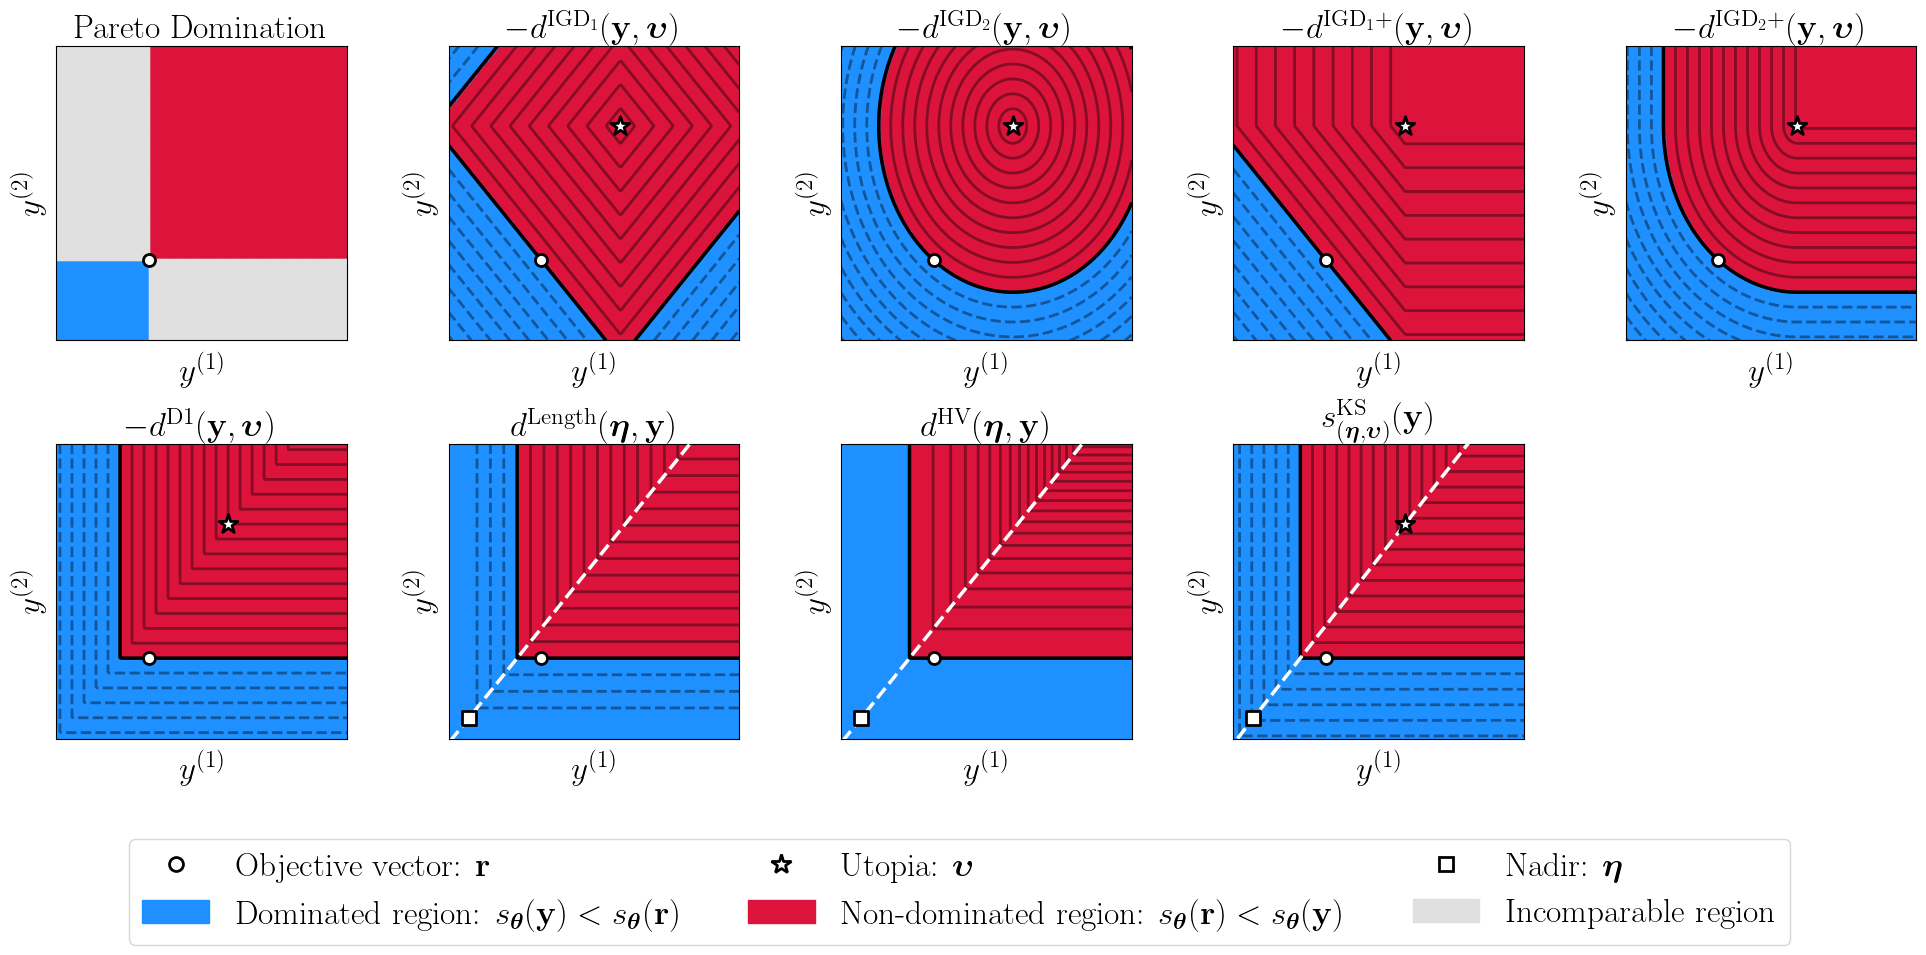

In [4]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 9), rasterized=True)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.35
)

plt.subplot(num_rows, num_cols, 1)
plot_pareto_domination(Z, r, "Pareto Domination", fontsize=24)

j = 1
for key, value in s_fn_dict.items():
    plt.subplot(num_rows, num_cols, j + 1)
    s_fn = value[0]
    Zr = s_fn(r)[..., 0]
    ZY = s_fn(Z)[..., 0]

    plot_scalarized_domination(
        Z,
        ZY,
        Zr,
        r,
        utopia_set=value[1],
        nadir_set=value[2],
        unit_vector=value[3],
        levels=value[4],
        title=key,
        contours=True,
        X=X,
        Y=Y,
        fontsize=24,
    )
    if "KS" in key:
        t = torch.linspace(-10, 10, 100).unsqueeze(-1)
        line = nadir[0, :] + t * (utopia - nadir)
        plt.plot(
            line[:, 0], line[:, 1], color="w", linestyle="--", linewidth=2.5, zorder=4
        )

    j = j + 1

axes[num_rows - 1, num_cols - 1].remove()

red_patch = mpatches.Patch(
    color="crimson",
    label=r"Non-dominated region: $s_{\boldsymbol{\theta}}(\mathbf{r}) < s_{\boldsymbol{\theta}}(\mathbf{y})$",
)
blue_patch = mpatches.Patch(
    color="dodgerblue",
    label=r"Dominated region: $s_{\boldsymbol{\theta}}(\mathbf{y}) < s_{\boldsymbol{\theta}}(\mathbf{r})$",
)
gray_patch = mpatches.Patch(color="#E0E0E0", label=r"Incomparable region", alpha=1)
black_dot = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Objective vector: $\mathbf{r}$",
)

white_star = mlines.Line2D(
    [],
    [],
    color="w",
    marker="*",
    linestyle="None",
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Utopia: $\boldsymbol{\upsilon}$",
)
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Nadir: $\boldsymbol{\eta}$",
)

axes[num_rows - 1][0].legend(
    handles=[black_dot, blue_patch, white_star, red_patch, white_square, gray_patch],
    ncol=3,
    fontsize=24,
    loc=(0.25, -0.7),
)

plt.show()